# Heliconius Gene Editing Dashboard

This dashboard acts as a tool to inspect perturbations on genotype-to-phenotype models.

Upon editing / changing genes, the resulting effect on the phenotype will be visualized.

## Initial Configurations
Edit configurations below

In [ ]:
import os
from pathlib import Path
from dataclasses import dataclass

import torch

from gtp.configs.loaders import load_configs
from gtp.configs.project import GenotypeToPhenotypeConfigs
from gtp.dataloading.path_collectors import (
    get_experiment_directory,
    get_post_processed_genotype_directory,
)
from gtp.dataloading.tools import collect_chromosome
from gtp.models.net import SoyBeanNet
from gtp.options.process_attribution import ProcessAttributionOptions

# SPECIFY GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = "cuda"


class GeneEditingDashboardState:
    def __init__(
        self,
        wing: str,
        species: str,
        color: str,
        chromosome: int,
        exp_name: str,
        config_path: str,
    ):
        self.wing = wing
        self.species = species
        self.color = color
        self.chromosome = chromosome
        self.exp_name = exp_name
        self.configs: GenotypeToPhenotypeConfigs = load_configs(config_path)
        self.model = None
        self.camids = None
        self.data = None

        self.load_data_and_model()

    def load_data_and_model(self):
        match self.exp_name:
            case "base":
                drop_out_prob = 0.75
                out_dims = 1
                out_dims_start_idx = 0
                insize = 3
                hidden_dim = 10
            case "pca_10":
                drop_out_prob = 0.75
                out_dims = 10
                out_dims_start_idx = 0
                insize = 3
                hidden_dim = 10
            case _:
                raise NotImplementedError(
                    f"Experiment {self.exp_name} isn't implemented for this visualization. Please create a case and update configs."
                )

        opts: ProcessAttributionOptions = ProcessAttributionOptions(
            drop_out_prob=drop_out_prob,
            out_dims=out_dims,
            out_dims_start_idx=out_dims_start_idx,
            insize=insize,
            hidden_dim=hidden_dim,
            species=self.species,
            chromosome=self.chromosome,
            color=self.color,
            wing=self.wing,
            exp_name=self.exp_name,
        )

        processed_genotype_dir = (
            get_post_processed_genotype_directory(self.configs.io)
            / self.configs.experiment.genotype_scope
        )

        # Collect genotype data
        self.camids, self.data = collect_chromosome(
            processed_genotype_dir, self.species, self.chromosome
        )

        self.model = SoyBeanNet(
            window_size=self.data.shape[1],
            num_out_dims=opts.out_dims,
            insize=opts.insize,
            hidden_dim=opts.hidden_dim,
            drop_out_prob=opts.drop_out_prob,
        )

        experiment_dir = get_experiment_directory(
            self.configs.io,
            species=self.species,
            wing=self.wing,
            color=self.color,
            chromosome=self.chromosome,
            exp_name=self.exp_name,
        )

        self.model.load_state_dict(
            torch.load(experiment_dir / "model.pt", weights_only=True)
        )
        self.model = self.model.to(device)
        self.model.eval()


"""
EDIT HERE
"""
gene_editing_dashboard_state = GeneEditingDashboardState(
    wing="forewings",
    species="erato",
    color="color_3",
    chromosome=18,
    exp_name="pca_10",
    config_path=Path("../configs/default.yaml"),
)

## Dashboard
Explore the model below

In [2]:
import ipywidgets as widgets


In [ ]:
from copy import copy
from dataclasses import dataclass

from ipywidgets import VBox, HBox
import plotly.graph_objs as go
import numpy as np
from captum.attr import LRP


def get_model_input(camid):
    input_idx = np.where(gene_editing_dashboard_state.camids == camid)[0][0]
    x = gene_editing_dashboard_state.data[input_idx]
    x = torch.tensor(x).unsqueeze(0).unsqueeze(0).float().to(device)
    return x


def get_model_output(input_x):
    with torch.no_grad():
        return gene_editing_dashboard_state.model(input_x)[0]


def get_attr(camid, target=0):
    att_model = LRP(gene_editing_dashboard_state.model)
    gene_editing_dashboard_state.model.zero_grad()
    x = get_model_input(camid)
    x.requires_grad = True
    attr = att_model.attribute(x, target=target)
    # For LRP, this (ONE-HOT state ex. [0,0,1] attributions) should be sum.
    # This is because the attribution scores should all add up to be the find value in the prediction, so averaging could break that.
    attr = attr.sum(-1)
    attr = attr[0, 0]  # Only has 1 channel, just extract it and is one batch item
    attr = attr.detach().cpu().numpy()

    return attr


debug_output_box = widgets.Textarea(value="", disabled=True)


def debug_log(txt):
    debug_output_box.value += f"\n{txt}"


@dataclass
class CurrentGeneState:
    text: str
    index: int


current_gene_state = CurrentGeneState(text="", index=0)

camid_dropdown_widget = widgets.Dropdown(
    options=gene_editing_dashboard_state.camids,
    value=gene_editing_dashboard_state.camids[0],
    description="CAMID",
    disabled=False,
)

num_pca = 10 if gene_editing_dashboard_state.exp_name == "pca_10" else 1
pca_attr_target_widget = widgets.Dropdown(
    options=range(0, num_pca),
    value=0,
    description="PCA Attribution Target",
    disabled=False,
)

current_gene_text_widget = widgets.Text(
    value=current_gene_state.text,
    placeholder="Gene",
    description="Current Gene",
    disabled=True,
    layout=widgets.Layout(width="100%"),
)

edit_btns = widgets.RadioButtons(
    options=["aa", "aA/Aa", "AA", "zero-out"],
)
edit_lbl = widgets.Label(value="Gene Edit")
gene_edit_btns = HBox([edit_lbl, edit_btns])

window_size_dd = widgets.Dropdown(
    options=list(range(0, 100001, 10000)),
    value=0,
    description="Window Size",
    disable=False,
)


class ManhattanPlotInteractive:
    def __init__(self):
        self.display_box = VBox([])
        self.update_data()

    def update_data(self, *args):
        self.camid = camid_dropdown_widget.value
        self.Y = get_attr(self.camid, target=int(pca_attr_target_widget.value))
        self.X = np.arange(len(self.Y))
        N = 1_000
        top_attr_idx = np.argsort(np.abs(self.Y))[::-1]
        self.top_n_idx = top_attr_idx[:N]
        self.top_X = self.X[self.top_n_idx]
        self.top_Y = self.Y[self.top_n_idx]

        self.update_plot()

    def _update_window_lines(self):
        window_size = int(window_size_dd.value)
        # Remove old lines if they exist
        self.figure_widget.layout.shapes = []
        if window_size > 0:
            gene_loc = current_gene_state.index
            min_x = max(0, gene_loc - window_size)
            max_x = min(len(self.X), gene_loc + window_size)
            # Add new lines
            self.figure_widget.add_vline(x=min_x, line_color="orange")
            self.figure_widget.add_vline(x=max_x, line_color="orange")

    def update_plot(self, *args):
        self.figure_widget = go.FigureWidget(
            [go.Scatter(x=self.top_X, y=self.top_Y, mode="markers")]
        )
        self.figure_widget.update_layout(
            title=dict(
                text=f"Model Attribution Plot - Chromosome {gene_editing_dashboard_state.chromosome} - {gene_editing_dashboard_state.species} - {gene_editing_dashboard_state.color}"
            ),
            xaxis=dict(title=dict(text="Gene Location")),
            yaxis=dict(title=dict(text="Model Attribution")),
            font=dict(family="Impact", size=18, color="RebeccaPurple"),
        )
        self._update_window_lines()

        # Set Initial Colors
        self.init_colors = ["#0000aa"] * len(self.top_X)
        scatter_plot = self.get_scatter_plot()
        scatter_plot.marker.color = self.init_colors

        # Register on-click events
        scatter_plot.on_click(self.handle_click)

        self.display_box.children = [self.figure_widget]

    def get_scatter_plot(self):
        return self.figure_widget.data[0]

    def handle_click(self, trace, points, state):
        print(points)
        idx = points.point_inds[0]
        x = points.xs[0]
        y = points.ys[0]

        current_gene_state.index = x
        input_x = get_model_input(camid_dropdown_widget.value)
        vec_state = input_x[0][0][x]
        gene_str = ""
        if vec_state[0].item() == 1:
            gene_str = "aa"
        elif vec_state[1].item() == 1:
            gene_str = "aA/Aa"
        if vec_state[2].item() == 1:
            gene_str = "AA"

        current_gene_state.text = f"({gene_str}) | Attribution: ({y}) | Position: ({x})"
        current_gene_text_widget.value = current_gene_state.text

        scatter_plot = self.get_scatter_plot()
        colors = copy(self.init_colors)
        colors[idx] = "#ff0000"
        with self.figure_widget.batch_update():
            scatter_plot.marker.color = colors

        self._update_window_lines()


manhattan_plot = ManhattanPlotInteractive()

camid_dropdown_widget.observe(manhattan_plot.update_data, "value")
pca_attr_target_widget.observe(manhattan_plot.update_data, "value")
window_size_dd.observe(manhattan_plot.update_data, "value")


In [8]:
from io import BytesIO
from ipywidgets import HBox
import pandas as pd

from PIL import Image
from matplotlib import cm

from gtp.dataloading.path_collectors import get_post_processed_phenotype_directory


def get_proj_matrix():
    cfgs = gene_editing_dashboard_state.configs
    species = gene_editing_dashboard_state.species
    wing = gene_editing_dashboard_state.wing
    color = gene_editing_dashboard_state.color
    proj_matrices_dir = Path(cfgs.io.default_root, "dna/projection_matrices")
    pca_df = pd.read_csv(proj_matrices_dir / f"{species}_{wing}_{color}.csv")
    pca_w = pca_df.to_numpy()
    return pca_w


def create_proj_img_bytes(pca_w, pca_vector):
    proj_img_m = pca_w @ pca_vector.T
    proj_img_m = proj_img_m.reshape(300, 300)  # Range between [-1, 1]
    # proj_img_m += 1
    # proj_img_m /= 2  # [0, 1]
    proj_img_m[proj_img_m <= 0] = 0
    proj_img_m[proj_img_m > 0] = 1
    im = Image.fromarray(np.uint8(cm.bwr(proj_img_m) * 255))

    im_bytes = BytesIO()
    im.save(im_bytes, format="PNG")
    return im_bytes


def get_org_pca_vector(camid):
    cfgs = gene_editing_dashboard_state.configs
    species = gene_editing_dashboard_state.species
    wing = gene_editing_dashboard_state.wing
    color = gene_editing_dashboard_state.color
    phenotype_folder = get_post_processed_phenotype_directory(cfgs.io)
    pca_df = pd.read_csv(phenotype_folder / f"{species}_{wing}_{color}" / "data.csv")
    results = pca_df.loc[pca_df.camid == camid]
    pca_vector = results.iloc[:1, 1:].to_numpy()
    return pca_vector


def get_proj_img(pca_vector):
    pca_w = get_proj_matrix()
    im_bytes = create_proj_img_bytes(pca_w, pca_vector)

    return im_bytes


class PCAProjectionView:
    def __init__(self):
        self.display_box = HBox([])
        self.update_data()

    def _update_data(self):
        camid = camid_dropdown_widget.value
        pca_output = get_org_pca_vector(camid)
        self.proj_img_bytes = get_proj_img(pca_output)

    def update_data(self, *args):
        self._update_data()
        self.update_plot()

    def update_plot(self):
        data_list = [round(x, 2) for x in self.pca_output.tolist()]
        self.figure_widget = go.FigureWidget(
            [
                go.Table(
                    header=dict(values=["PCA"]),
                    cells=dict(values=[data_list]),
                )
            ]
        )

        self.proj_img = widgets.Image(
            value=self.proj_img_bytes.getvalue(),
            format="png",
        )

        self.display_box.children = [self.figure_widget, self.proj_img]


def get_model_pca_view(input_x, camid):
    output = get_model_output(input_x)
    pca_output = output.detach().cpu().numpy()
    D = pca_output.shape[0]
    pca_vector = get_org_pca_vector(camid)
    pca_vector[0, :D] = pca_output
    return pca_vector


class OrgPCAProjectionView(PCAProjectionView):
    def _update_data(self):
        camid = camid_dropdown_widget.value
        pca_output = get_org_pca_vector(camid)
        print(pca_output.shape)
        self.proj_img_bytes = get_proj_img(pca_output)
        self.pca_output = pca_output[0]


class ModelPCAProjectionView(PCAProjectionView):
    def _get_model_input(self, camid):
        input_x = get_model_input(camid)
        return input_x

    def _update_data(self):
        camid = camid_dropdown_widget.value
        input_x = self._get_model_input(camid)
        pca_vector = get_model_pca_view(input_x, camid)
        self.proj_img_bytes = get_proj_img(pca_vector)
        self.pca_output = pca_vector[0]


class ModelEditPCAProjectionView(ModelPCAProjectionView):
    def _get_model_input(self, camid):
        input_x = super()._get_model_input(camid)
        loc = current_gene_state.index
        edit_gene_str = edit_btns.value
        ws = window_size_dd.value

        if edit_gene_str == "AA":
            edit_vec = torch.tensor([0, 0, 1])
        elif edit_gene_str == "aa":
            edit_vec = torch.tensor([1, 0, 0])
        elif edit_gene_str == "aA/Aa":
            edit_vec = torch.tensor([0, 1, 0])
        else:
            edit_vec = torch.tensor([0, 0, 0])

        if ws != 0:
            min_idx = max(0, loc - ws)
            max_idx = min(input_x.shape[2], loc + ws)
            edit_vec = edit_vec.unsqueeze(0).repeat(max_idx - min_idx, 1)

        if ws == 0:
            input_x[0][0][loc] = edit_vec
        else:
            input_x[0][0][min_idx:max_idx] = edit_vec

        return input_x


class ModelEditDiffPCAProjectionView(PCAProjectionView):
    def __init__(self, model_pca_proj_view, model_edit_pca_proj_view):
        self.model_pca_proj_view: PCAProjectionView = model_pca_proj_view
        self.model_edit_pca_proj_view: PCAProjectionView = model_edit_pca_proj_view
        super().__init__()

    def _update_data(self):
        model_pca = self.model_pca_proj_view.pca_output
        model_edit_pca = self.model_edit_pca_proj_view.pca_output
        self.pca_output = model_edit_pca - model_pca

        model_img = Image.open(self.model_pca_proj_view.proj_img_bytes)
        edit_model_img = Image.open(self.model_edit_pca_proj_view.proj_img_bytes)

        diff_img = (np.array(model_img) - np.array(edit_model_img)).astype(np.float64)
        diff_img = diff_img.sum(-1)
        diff_img -= diff_img.min()
        if diff_img.max() != 0:
            diff_img /= diff_img.max()

        diff_img = Image.fromarray(
            np.uint8(
                cm.bwr(
                    diff_img,
                )
                * 255
            )
        )
        self.proj_img_bytes = BytesIO()
        diff_img.save(self.proj_img_bytes, format="png")


original_pca_projection = OrgPCAProjectionView()
camid_dropdown_widget.observe(original_pca_projection.update_data, "value")

model_pca_projection = ModelPCAProjectionView()
camid_dropdown_widget.observe(model_pca_projection.update_data, "value")

model_edit_pca_projection = ModelEditPCAProjectionView()
camid_dropdown_widget.observe(model_edit_pca_projection.update_data, "value")
edit_btns.observe(model_edit_pca_projection.update_data, "value")
window_size_dd.observe(model_edit_pca_projection.update_data, "value")
current_gene_text_widget.observe(model_edit_pca_projection.update_data, "value")

model_edit_diff_pca_projection = ModelEditDiffPCAProjectionView(
    model_pca_projection, model_edit_pca_projection
)
camid_dropdown_widget.observe(model_edit_diff_pca_projection.update_data, "value")
edit_btns.observe(model_edit_diff_pca_projection.update_data, "value")
window_size_dd.observe(model_edit_diff_pca_projection.update_data, "value")
current_gene_text_widget.observe(model_edit_diff_pca_projection.update_data, "value")

(1, 480)


In [9]:
from ipywidgets import TwoByTwoLayout

projection_grid = TwoByTwoLayout(
    top_left=original_pca_projection.display_box,
    top_right=model_pca_projection.display_box,
    bottom_left=model_edit_pca_projection.display_box,
    bottom_right=model_edit_diff_pca_projection.display_box,
)

In [10]:
display(camid_dropdown_widget)
display(pca_attr_target_widget)
display(manhattan_plot.display_box)
display(current_gene_text_widget)
display(gene_edit_btns)
display(window_size_dd)
display(projection_grid)
display(debug_output_box)

Dropdown(description='CAMID', options=(np.str_('CAM016019'), np.str_('CAM016020'), np.str_('CAM016021'), np.st…

Dropdown(description='PCA Attribution Target', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0)

    'data': [{'marker': {'color': [#0000aa, #0000aa, #0000aa, ..., #0000aa,
    …

Text(value='', description='Current Gene', disabled=True, layout=Layout(width='100%'), placeholder='Gene')

Dropdown(description='Window Size', options=(0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000,…

TwoByTwoLayout(children=(HBox(children=(FigureWidget({
    'data': [{'cells': {'values': [[-20.97, -18.23, 4.9…

Textarea(value='', disabled=True)

In [ ]:
import math
from collections import defaultdict
from tqdm.auto import tqdm

ws = int(window_size_dd.value)
num_of_edits = math.ceil(len(manhattan_plot.X) / (ws * 2))
change_tracker = defaultdict(list)
for edit_num in tqdm(range(num_of_edits), desc="recording changes", colour="#8822CC"):
    x = min((edit_num * ws * 2) + ws, len(manhattan_plot.X))
    current_gene_state.index = x
    current_gene_state.text = f"Position {x}"
    current_gene_text_widget.value = current_gene_state.text
    for edit_value in edit_btns.options:
        edit_btns.value = edit_value
    l2_dist = np.sqrt((model_edit_diff_pca_projection.pca_output**2).sum())
    change_tracker[edit_num].append(l2_dist)

recording changes:   0%|          | 0/83 [00:00<?, ?it/s]

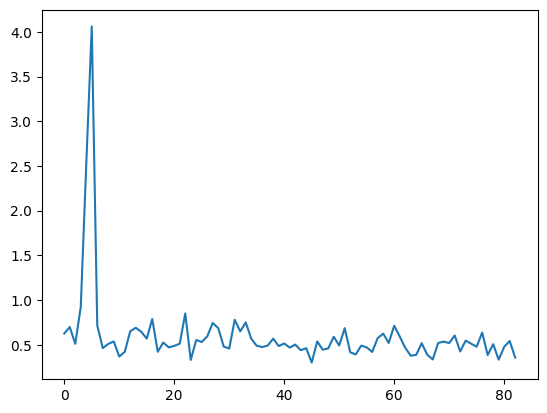

In [67]:
import matplotlib.pyplot as plt

data = np.array([(x, ys[0]) for x, ys in change_tracker.items()])
plt.plot(data[:, 0], data[:, 1])